# Ray Train etc ...


In [1]:
import ray
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ray.shutdown()

In [3]:
ray.init()

2023-03-16 21:21:21,942	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.16
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [4]:
# Load data.
dataset = ray.data.read_csv("s3://anonymous@air-example-data/breast_cancer.csv").repartition(6)

# Split data into train and validation.
train_dataset, valid_dataset = dataset.train_test_split(test_size=0.3)

# Create a test dataset by dropping the target column.
test_dataset = valid_dataset.drop_columns(cols=["target"])

2023-03-16 21:21:30,127	WARNING read_api.py:330 -- ⚠️  The number of blocks in this dataset (1) limits its parallelism to 1 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
2023-03-16 21:21:30,149	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[read] -> AllToAllOperator[repartition]
Repartition: 100%|████████████████████████████████| 6/6 [00:00<00:00, 17.87it/s]


In [5]:
# Create a preprocessor to scale some columns.
from ray.data.preprocessors import StandardScaler

preprocessor = StandardScaler(columns=["mean radius", "mean texture"])

In [24]:
from ray.air.config import ScalingConfig
from ray.train.xgboost import XGBoostTrainer

trainer = XGBoostTrainer(
    scaling_config=ScalingConfig(
        # Number of workers to use for data parallelism.
        num_workers=3,#1,#2,
        resources_per_worker={'CPU': 2},
        # Whether to use GPU acceleration.
        use_gpu=False,
        # Make sure to leave some CPUs free for Ray Data operations.
        _max_cpu_fraction_per_node=0.5,
    ),
    label_column="target",
    num_boost_round=20,
    params={
        # XGBoost specific params
        "objective": "binary:logistic",
        # "tree_method": "gpu_hist",  # uncomment this to use GPUs.
        "eval_metric": ["logloss", "error"],
    },
    datasets={"train": train_dataset, "valid": valid_dataset},
    preprocessor=preprocessor,
)
result = trainer.fit()
print(result.metrics)

2023-03-16 21:56:14,820	WARNING tune.py:146 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2023-03-16 21:56:17,846	ERROR tune.py:794 -- Trials did not complete: [XGBoostTrainer_401d4_00000]
2023-03-16 21:56:17,847	INFO tune.py:798 -- Total run time: 55.27 seconds (55.25 seconds for the tuning loop).
2023-03-16 21:56:17,848	WARNING tune.py:804 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


{'trial_id': '401d4_00000'}


In [7]:
def train_xgboost_model(num_workers, num_cpus):
    trainer = XGBoostTrainer(
    scaling_config=ScalingConfig(
        # Number of workers to use for data parallelism.
        num_workers=num_workers,
        resources_per_worker={'CPU': num_cpus},
        # Whether to use GPU acceleration.
        use_gpu=False,
        # Make sure to leave some CPUs free for Ray Data operations.
        _max_cpu_fraction_per_node=0.9,
    ),
    label_column="target",
    num_boost_round=20,
    params={
        # XGBoost specific params
        "objective": "binary:logistic",
        # "tree_method": "gpu_hist",  # uncomment this to use GPUs.
        "eval_metric": ["logloss", "error"],
    },
    datasets={"train": train_dataset, "valid": valid_dataset},
    preprocessor=preprocessor,
    )
    result = trainer.fit()
    return result


In [8]:
trial_results = []

num_workers=1
for num_cpus in [1,2,3,4,5,6]:
    result = train_xgboost_model(num_workers=num_workers, num_cpus=num_cpus)
    result_dict = result.metrics
    result_dict['num_workers'] = num_workers
    result_dict['num_cpus'] = num_cpus
    trial_results.append(result_dict)
    
num_workers=2
for num_cpus in [1,2,3]:
    result = train_xgboost_model(num_workers=num_workers, num_cpus=num_cpus)
    result_dict = result.metrics
    result_dict['num_workers'] = num_workers
    result_dict['num_cpus'] = num_cpus
    trial_results.append(result_dict)

pd.DataFrame(trial_results)  

(XGBoostTrainer pid=5568) 2023-03-16 21:21:42,813	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=5568) 2023-03-16 21:21:42,831	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5568) 2023-03-16 21:21:42,875	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5568) /Users/apmcm/Library/Caches/pypoetry/virtualenvs/mlewp2-ray-bRNhCFd1-py3.9/lib/python3.9/site-packages/xgboost_ray/main.py:473: UserWarning: `num_actors` in `ray_params` is smaller than 2 (1). XGBoost will NOT be distributed!
(XGBoostTrainer pid=5568)   warnings.warn(
(XGBoostTrainer pid=5568) 2023-03-16 21:21:46,662	INFO tracker.py:218 -- start listen on 127.0.0.1:50083
(XGBoostTrainer pid=5568) 2023-03-16 21:21:46,679	INFO tracker.py:382 -- @tracker All of 1 nodes getting started
(_RemoteRayXGBoostActor pid=5579)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_8b69d_00000,2023-03-16_21-21-49,True,,933451148dae4268b131103cbd496fcf,0,Andrews-MacBook-Pro.local,21,127.0.0.1,5568,True,6.38673,0.937224,6.38673,1679001709,0,,0,0.0186958,21,8b69d_00000,0.0350877,0.0926329,0.00466084


2023-03-16 21:21:49,220	INFO tune.py:798 -- Total run time: 7.79 seconds (7.79 seconds for the tuning loop).


(XGBoostTrainer pid=5582) 2023-03-16 21:21:50,983	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=5582) 2023-03-16 21:21:52,373	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5582) 2023-03-16 21:21:52,392	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5582) /Users/apmcm/Library/Caches/pypoetry/virtualenvs/mlewp2-ray-bRNhCFd1-py3.9/lib/python3.9/site-packages/xgboost_ray/main.py:473: UserWarning: `num_actors` in `ray_params` is smaller than 2 (1). XGBoost will NOT be distributed!
(XGBoostTrainer pid=5582)   warnings.warn(
(XGBoostTrainer pid=5582) 2023-03-16 21:21:54,006	INFO tracker.py:218 -- start listen on 127.0.0.1:50197
(XGBoostTrainer pid=5582) 2023-03-16 21:21:54,020	INFO tracker.py:382 -- @tracker All of 1 nodes getting started
(_RemoteRayXGBoostActor pid=5587)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_90105_00000,2023-03-16_21-21-56,True,,106239ad8b8a43718e52366237ef8f2e,0,Andrews-MacBook-Pro.local,21,127.0.0.1,5582,True,5.61972,1.02107,5.61972,1679001716,0,,0,0.0186958,21,90105_00000,0.0350877,0.0926329,0.00493979


2023-03-16 21:21:56,629	INFO tune.py:798 -- Total run time: 7.40 seconds (7.39 seconds for the tuning loop).


(XGBoostTrainer pid=5590) 2023-03-16 21:21:58,429	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=5590) 2023-03-16 21:21:58,446	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5590) 2023-03-16 21:21:58,474	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5590) /Users/apmcm/Library/Caches/pypoetry/virtualenvs/mlewp2-ray-bRNhCFd1-py3.9/lib/python3.9/site-packages/xgboost_ray/main.py:473: UserWarning: `num_actors` in `ray_params` is smaller than 2 (1). XGBoost will NOT be distributed!
(XGBoostTrainer pid=5590)   warnings.warn(
(XGBoostTrainer pid=5590) 2023-03-16 21:22:02,109	INFO tracker.py:218 -- start listen on 127.0.0.1:50320
(XGBoostTrainer pid=5590) 2023-03-16 21:22:02,126	INFO tracker.py:382 -- @tracker All of 1 nodes getting started
(_RemoteRayXGBoostActor pid=5597)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_947ae_00000,2023-03-16_21-22-03,True,,b214fcb1aff447929085a37bc47116b6,0,Andrews-MacBook-Pro.local,21,127.0.0.1,5590,True,5.24858,0.0256381,5.24858,1679001723,0,,0,0.0186958,21,947ae_00000,0.0350877,0.0926329,0.00848985


2023-03-16 21:22:03,683	INFO tune.py:798 -- Total run time: 7.05 seconds (7.04 seconds for the tuning loop).


(XGBoostTrainer pid=5600) 2023-03-16 21:22:05,421	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=5600) 2023-03-16 21:22:05,927	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5600) 2023-03-16 21:22:05,954	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5600) /Users/apmcm/Library/Caches/pypoetry/virtualenvs/mlewp2-ray-bRNhCFd1-py3.9/lib/python3.9/site-packages/xgboost_ray/main.py:473: UserWarning: `num_actors` in `ray_params` is smaller than 2 (1). XGBoost will NOT be distributed!
(XGBoostTrainer pid=5600)   warnings.warn(
(XGBoostTrainer pid=5600) 2023-03-16 21:22:08,164	INFO tracker.py:218 -- start listen on 127.0.0.1:50419
(XGBoostTrainer pid=5600) 2023-03-16 21:22:08,177	INFO tracker.py:382 -- @tracker All of 1 nodes getting started
(_RemoteRayXGBoostActor pid=5605)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_98aec_00000,2023-03-16_21-22-10,True,,7711a011c37345b59827d82ad0b74de3,0,Andrews-MacBook-Pro.local,21,127.0.0.1,5600,True,5.31662,1.00126,5.31662,1679001730,0,,0,0.0186958,21,98aec_00000,0.0350877,0.0926329,0.00502086


2023-03-16 21:22:10,755	INFO tune.py:798 -- Total run time: 7.07 seconds (7.06 seconds for the tuning loop).


(XGBoostTrainer pid=5608) 2023-03-16 21:22:12,473	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=5608) 2023-03-16 21:22:12,801	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5608) 2023-03-16 21:22:12,820	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5608) /Users/apmcm/Library/Caches/pypoetry/virtualenvs/mlewp2-ray-bRNhCFd1-py3.9/lib/python3.9/site-packages/xgboost_ray/main.py:473: UserWarning: `num_actors` in `ray_params` is smaller than 2 (1). XGBoost will NOT be distributed!
(XGBoostTrainer pid=5608)   warnings.warn(
(XGBoostTrainer pid=5608) 2023-03-16 21:22:14,439	INFO tracker.py:218 -- start listen on 127.0.0.1:50497
(XGBoostTrainer pid=5608) 2023-03-16 21:22:14,452	INFO tracker.py:382 -- @tracker All of 1 nodes getting started
(_RemoteRayXGBoostActor pid=5611)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_9ce66_00000,2023-03-16_21-22-16,True,,1a8613ed50104529953f3032ae649844,0,Andrews-MacBook-Pro.local,21,127.0.0.1,5608,True,4.51388,0.978632,4.51388,1679001736,0,,0,0.0186958,21,9ce66_00000,0.0350877,0.0926329,0.00511217


2023-03-16 21:22:17,005	INFO tune.py:798 -- Total run time: 6.24 seconds (6.23 seconds for the tuning loop).


(XGBoostTrainer pid=5614) 2023-03-16 21:22:18,722	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=5614) 2023-03-16 21:22:18,737	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5614) 2023-03-16 21:22:18,757	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5614) /Users/apmcm/Library/Caches/pypoetry/virtualenvs/mlewp2-ray-bRNhCFd1-py3.9/lib/python3.9/site-packages/xgboost_ray/main.py:473: UserWarning: `num_actors` in `ray_params` is smaller than 2 (1). XGBoost will NOT be distributed!
(XGBoostTrainer pid=5614)   warnings.warn(
(XGBoostTrainer pid=5614) 2023-03-16 21:22:20,362	INFO tracker.py:218 -- start listen on 127.0.0.1:50576
(XGBoostTrainer pid=5614) 2023-03-16 21:22:20,375	INFO tracker.py:382 -- @tracker All of 1 nodes getting started
(_RemoteRayXGBoostActor pid=5617)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_a0a01_00000,2023-03-16_21-22-22,True,,5f43ad92a10c4c9e8a35b452cc6f429a,0,Andrews-MacBook-Pro.local,21,127.0.0.1,5614,True,4.1704,0.858688,4.1704,1679001742,0,,0,0.0186958,21,a0a01_00000,0.0350877,0.0926329,0.00493431


2023-03-16 21:22:22,911	INFO tune.py:798 -- Total run time: 5.90 seconds (5.89 seconds for the tuning loop).


(XGBoostTrainer pid=5619) 2023-03-16 21:22:24,171	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=5619) 2023-03-16 21:22:24,189	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5619) 2023-03-16 21:22:24,233	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler]
(XGBoostTrainer pid=5619) 2023-03-16 21:22:28,962	INFO tracker.py:218 -- start listen on 127.0.0.1:50721
(XGBoostTrainer pid=5619) 2023-03-16 21:22:28,980	INFO tracker.py:382 -- @tracker All of 2 nodes getting started
(_RemoteRayXGBoostActor pid=5629) [21:22:28] task [xgboost.ray]:5925535904 got new rank 1
(_RemoteRayXGBoostActor pid=5628) [21:22:28] task [xgboost.ray]:4925112432 got new rank 0
(XGBoostTrainer pid=5619) 2023-03-16 21:22:29,469	INFO tracker.py:388 -- @tracker All nodes finishes job


Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_a4252_00000,2023-03-16_21-22-31,True,,c2e77a7d8f68442d915856a47add4a70,0,Andrews-MacBook-Pro.local,21,127.0.0.1,5619,True,7.27477,0.807832,7.27477,1679001751,0,,0,0.0182011,21,a4252_00000,0.0411765,0.0957057,0.00561428


2023-03-16 21:22:31,467	INFO tune.py:798 -- Total run time: 8.55 seconds (8.54 seconds for the tuning loop).


(XGBoostTrainer pid=5632) 2023-03-16 21:22:33,216	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=5632) 2023-03-16 21:22:33,772	WARNING plan.py:523 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(XGBoostTrainer pid=5632) 2023-03-16 21:22:33,773	WARNING plan.py:523 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(XGBoostTrainer pid=5632) 2023-03-16 21:22:33,774	INFO bulk_executor

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_a93ed_00000,2023-03-16_21-22-39,True,,c593160ba45e4c16a095f64351848f97,0,Andrews-MacBook-Pro.local,21,127.0.0.1,5632,True,6.01239,0.732884,6.01239,1679001759,0,,0,0.0182011,21,a93ed_00000,0.0411765,0.0957057,0.00497389


2023-03-16 21:22:39,246	INFO tune.py:798 -- Total run time: 7.77 seconds (7.76 seconds for the tuning loop).


(XGBoostTrainer pid=5647) 2023-03-16 21:22:40,948	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
(XGBoostTrainer pid=5647) 2023-03-16 21:22:41,271	WARNING plan.py:523 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(XGBoostTrainer pid=5647) 2023-03-16 21:22:41,272	WARNING plan.py:523 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(XGBoostTrainer pid=5647) 2023-03-16 21:22:41,273	INFO bulk_executor

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,train-error,train-logloss,training_iteration,trial_id,valid-error,valid-logloss,warmup_time
XGBoostTrainer_ade1c_00000,2023-03-16_21-22-45,True,,3a3074f582614e1aa999829e7a753cfc,0,Andrews-MacBook-Pro.local,21,127.0.0.1,5647,True,4.62243,0.934236,4.62243,1679001765,0,,0,0.0182011,21,ade1c_00000,0.0411765,0.0957057,0.00514579


2023-03-16 21:22:45,590	INFO tune.py:798 -- Total run time: 6.34 seconds (6.33 seconds for the tuning loop).


,train-logloss,train-error,valid-logloss,valid-error,time_this_iter_s,should_checkpoint,done,timesteps_total,episodes_total,training_iteration,...,hostname,node_ip,config,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,experiment_tag,num_workers,num_cpus
0,0.018696,0.0,0.092633,0.035088,0.937224,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},6.386732,0,21,0.004661,0,1,1
1,0.018696,0.0,0.092633,0.035088,1.021074,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},5.619720,0,21,0.004940,0,1,2
2,0.018696,0.0,0.092633,0.035088,0.025638,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},5.248580,0,21,0.008490,0,1,3
3,0.018696,0.0,0.092633,0.035088,1.001257,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},5.316619,0,21,0.005021,0,1,4
4,0.018696,0.0,0.092633,0.035088,0.978632,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},4.513882,0,21,0.005112,0,1,5
5,0.018696,0.0,0.092633,0.035088,0.858688,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},4.170404,0,21,0.004934,0,1,6
6,0.018201,0.0,0.095706,0.041176,0.807832,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},7.274767,0,21,0.005614,0,2,1
7,0.018201,0.0,0.095706,0.041176,0.732884,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},6.012388,0,21,0.004974,0,2,2
8,0.018201,0.0,0.095706,0.041176,0.934236,True,True,None,None,21,...,Andrews-MacBook-Pro.local,127.0.0.1,{},4.622432,0,21,0.005146,0,2,3


An interesting result that as the number of workers goes up, so does this time. This is actually because increasing the number of workers on a single node won't reall

In [9]:
result.metrics_dataframe.columns

Index(['train-logloss', 'train-error', 'valid-logloss', 'valid-error',
       'time_this_iter_s', 'done', 'timesteps_total', 'episodes_total',
       'training_iteration', 'trial_id', 'experiment_id', 'date', 'timestamp',
       'time_total_s', 'pid', 'hostname', 'node_ip', 'time_since_restore',
       'timesteps_since_restore', 'iterations_since_restore', 'warmup_time'],
      dtype='object')

In [10]:
result.metrics_dataframe[['training_iteration','train-logloss']]

,training_iteration,train-logloss
0,1,0.464118
1,2,0.333279
2,3,0.252174
3,4,0.192882
4,5,0.149095
5,6,0.117648
6,7,0.095098
7,8,0.078028
8,9,0.064818
9,10,0.055212


In [11]:
pd.DataFrame(trial_results)[['num_workers','num_cpus', 'time_total_s']]

,num_workers,num_cpus,time_total_s
0,1,1,6.386732
1,1,2,5.619720
2,1,3,5.248580
3,1,4,5.316619
4,1,5,4.513882
5,1,6,4.170404
6,2,1,7.274767
7,2,2,6.012388
8,2,3,4.622432


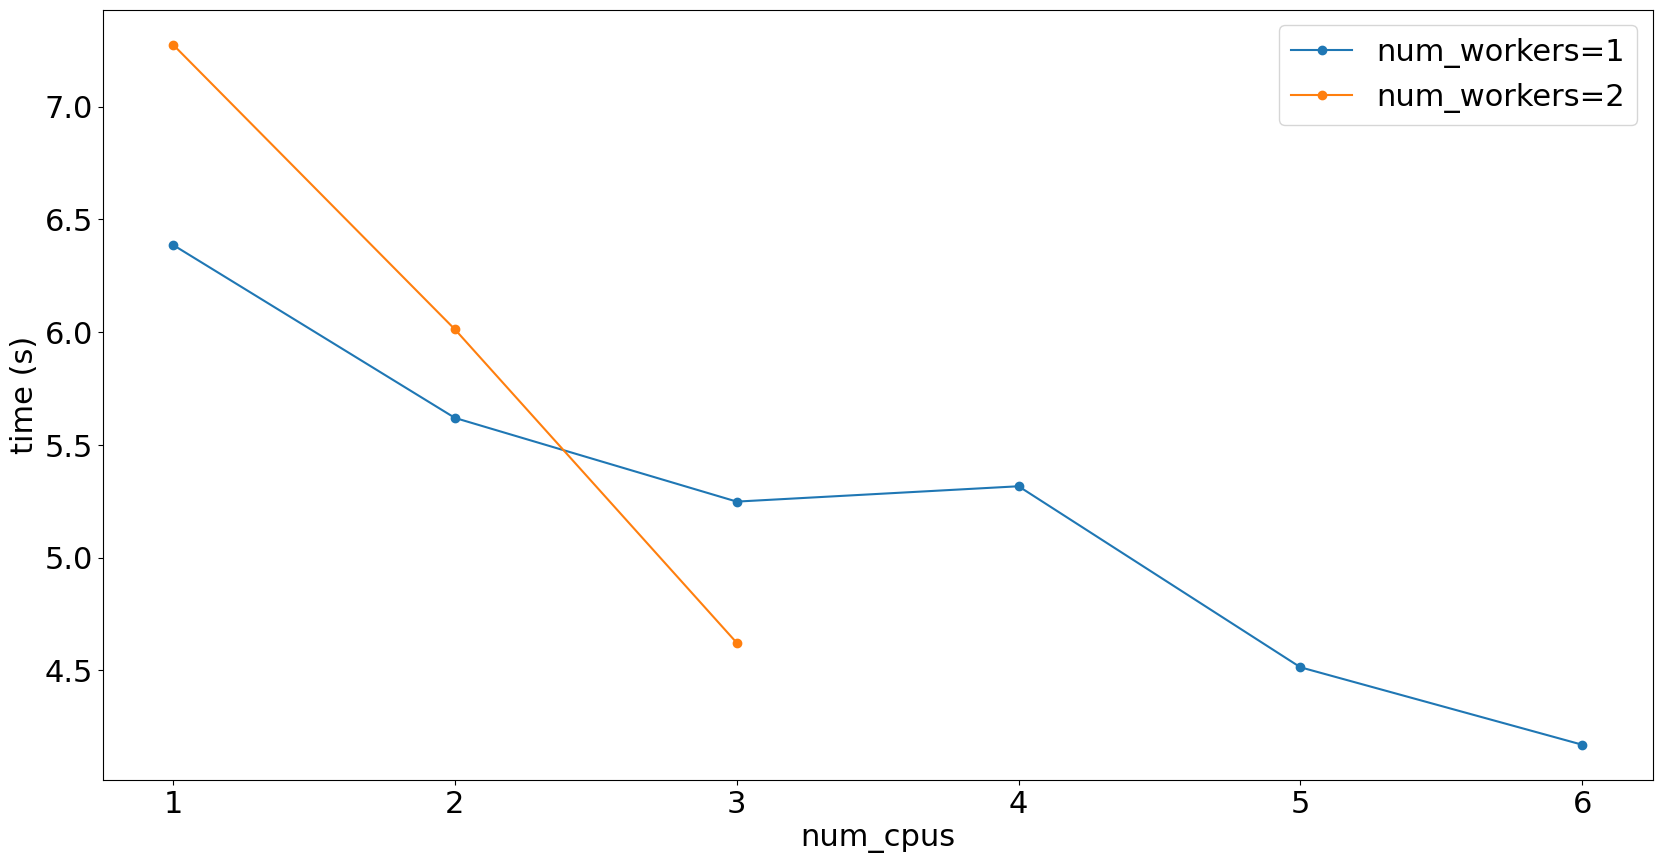

In [16]:
plt.rcParams.update({'font.size': 22})


plt.figure(figsize=(20,10))
pd.DataFrame(trial_results)[['num_workers','num_cpus', 'time_total_s']].\
set_index('num_cpus').\
groupby('num_workers')['time_total_s'].plot(
    legend=True, marker='o',
)
plt.ylabel('time (s)')
plt.legend(['num_workers=1', 'num_workers=2'])

# Ray AIR attempt

In [13]:
import numpy as np
from ray.data.preprocessors import Concatenator, Chain, StandardScaler

# Create a preprocessor to scale some columns and concatenate the result.
preprocessor = Chain(
    StandardScaler(columns=["mean radius", "mean texture"]),
    Concatenator(exclude=["target"], dtype=np.float32),
)

In [14]:
import torch
import torch.nn as nn

from ray import train
from ray.air import session
from ray.air.config import ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer


def create_model(input_features):
    return nn.Sequential(
        nn.Linear(in_features=input_features, out_features=16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU(),
        nn.Linear(16, 1),
        nn.Sigmoid(),
    )


def train_loop_per_worker(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["num_epochs"]
    num_features = config["num_features"]

    # Get the Ray Dataset shard for this data parallel worker,
    # and convert it to a PyTorch Dataset.
    train_data = session.get_dataset_shard("train")
    # Create model.
    model = create_model(num_features)
    model = train.torch.prepare_model(model)

    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for cur_epoch in range(epochs):
        for batch in train_data.iter_torch_batches(
            batch_size=batch_size, dtypes=torch.float32
        ):
            # "concat_out" is the output column of the Concatenator.
            inputs, labels = batch["concat_out"], batch["target"]
            optimizer.zero_grad()
            predictions = model(inputs)
            train_loss = loss_fn(predictions, labels.unsqueeze(1))
            train_loss.backward()
            optimizer.step()
        loss = train_loss.item()
        session.report({"loss": loss}, checkpoint=TorchCheckpoint.from_model(model))


num_features = len(train_dataset.schema().names) - 1

trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config={
        "batch_size": 128,
        "num_epochs": 20,
        "num_features": num_features,
        "lr": 0.001,
    },
    scaling_config=ScalingConfig(
        num_workers=3,  # Number of workers to use for data parallelism.
        use_gpu=False,
        trainer_resources={"CPU": 0},  # so that the example works on Colab.
    ),
    datasets={"train": train_dataset},
    preprocessor=preprocessor,
)

2023-03-16 21:22:46,046	INFO instantiator.py:21 -- Created a temporary directory at /var/folders/xk/jd8rqnqx039d6l59bvv6j0l80000gn/T/tmpmjq8ew7j
2023-03-16 21:22:46,047	INFO instantiator.py:76 -- Writing /var/folders/xk/jd8rqnqx039d6l59bvv6j0l80000gn/T/tmpmjq8ew7j/_remote_module_non_scriptable.py


In [15]:
# Execute training.
result = trainer.fit()
# print(f"Last result: {result.metrics}")
# # Last result: {'loss': 0.6559339960416158, ...}

(TorchTrainer pid=5657) 2023-03-16 21:22:48,090	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[randomize_block_order] -> AllToAllOperator[aggregate]
(TorchTrainer pid=5657) 2023-03-16 21:22:48,111	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler] -> AllToAllOperator[randomize_block_order]
(TorchTrainer pid=5657) 2023-03-16 21:22:48,154	INFO bulk_executor.py:39 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[StandardScaler] -> AllToAllOperator[randomize_block_order]
(TorchTrainer pid=5657) 2023-03-16 21:22:48,255	WARNING plan.py:523 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/master/data/dataset-internals.html#datasets-and-tune
(TorchTrainer pid=5657) 2023-03-

Trial name,_time_this_iter_s,_timestamp,_training_iteration,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
TorchTrainer_b1f1e_00000,0.0447719,1679001774,20,2023-03-16_21-22-54,True,,74246fb85ea04ba88608c42ba9cad8cb,0,Andrews-MacBook-Pro.local,20,0.713913,127.0.0.1,5657,True,6.56302,0.044642,6.56302,1679001774,0,,20,b1f1e_00000,0.00573897


2023-03-16 21:22:57,473	INFO tune.py:798 -- Total run time: 11.40 seconds (11.39 seconds for the tuning loop).
